<a href="https://colab.research.google.com/github/nomomon/NLP-course-project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os 
import re 

from tqdm import tqdm

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset

In [ ]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

In [ ]:
# en_url = "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en"
# de_url = "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de"

# en_file = tf.keras.utils.get_file("train.en", en_url)
# de_file = tf.keras.utils.get_file("train.de", de_url)

# # en_file = '/Users/mansurnurmukhambetov/.keras/datasets/train.en'
# # de_file = '/Users/mansurnurmukhambetov/.keras/datasets/train.de'

In [ ]:
# file = open(de_file, 'r')
# len(file.readlines())

In [ ]:
# file = open(en_file, 'r')
# len(file.readlines())

## Preprocessing

In [ ]:
with open("deu.txt", "r") as f:
    print(f.read()[:100])

In [ ]:
def make_dataset(lang):
    df = pd.read_csv("deu.txt", sep="\t", header=None)
    df.columns = ["en", "de", ""]

    df = df.applymap(
        lambda string: re.sub("\s+", " ", 
                                re.sub(r"[^A-Za-z0-9äöüÄÖÜß]", " ", string)
        )
    )

    df =  df.applymap(lambda string: string.lower())
    df = df[[lang]]

    df.columns = ["sentence"]

    return df

In [8]:
# def make_dataset(file_path):
#     # read file
#     with open(file_path, "r") as f:
#         lines = f.read().splitlines()

#     # create DataFrame
#     dataset = pd.DataFrame({"sentence": lines})

#     # remove non-alphanumeric, punctuation and german ulmauts
#     dataset = dataset.applymap(
#         lambda string: re.sub("\s+", " ", 
#                               re.sub(r"[^A-Za-z0-9äöüÄÖÜß]", " ", string)
#         )
#     ) # (),!?\'\`

#     # convert text to lowercase
#     dataset =  dataset.applymap(lambda string: string.lower())

#     return dataset
    
en_dataset = make_dataset("en")
de_dataset = make_dataset("de")

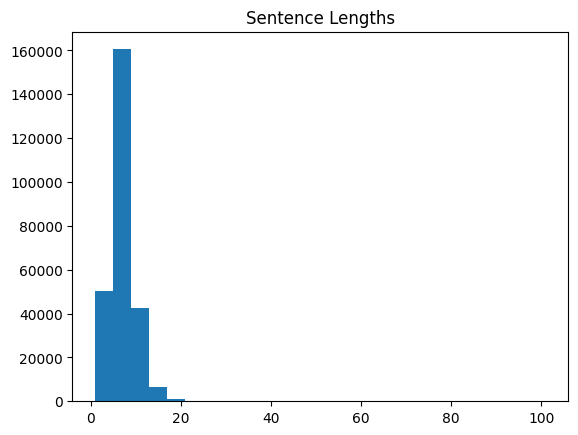

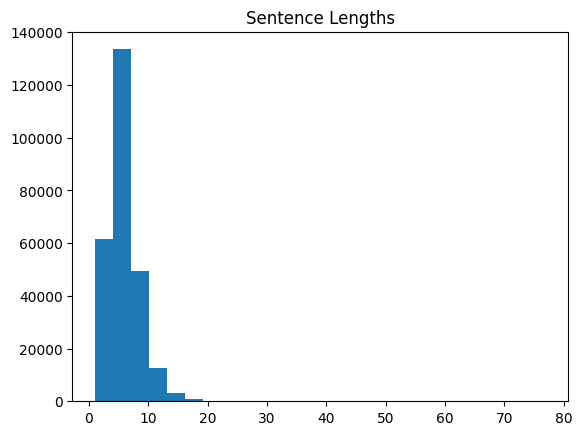

In [9]:
# visualize sentence lengths

def visualize_sentence_lengths(dataset):
    lengths = dataset.sentence.str.split().str.len()

    plt.title("Sentence Lengths")
    plt.hist(lengths, bins=25)
    plt.show()
    return lengths

en_lengths = visualize_sentence_lengths(en_dataset)
de_lengths = visualize_sentence_lengths(de_dataset);

In [10]:
en_length = 40
de_length = 40

## Tokenization

In [65]:
class Tokenizer():
    def __init__(self, num_words):
        self.num_words = num_words
        self.vocab = {}
        self.inv_vocab = {}


    # def split(self, text):
    #     return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

    def fit_on_texts(self, corpus):
        x = corpus.astype('U')
        x = np.char.split(x)
        x = np.concatenate(x).ravel()
        u, c = np.unique(x, return_counts=True)
        count_sort_ind = np.argsort(-c)
        u = u[count_sort_ind][:self.num_words]
        i = np.arange(4, len(u)+4)

        self.vocab = dict(zip(u, i))
        self.vocab["<sos>"] = 0
        self.vocab["<eos>"] = 1
        self.vocab["<unk>"] = 2
        self.vocab["<pad>"] = 3
        self.inv_vocab = {v:k for k, v in self.vocab.items()}

    def t2i(self, token):
        if token in self.vocab:
            return self.vocab[token]
        else: 
            return 2 # idx of <unk>

    def i2t(self, idx):
        if idx in self.inv_vocab:
            return self.inv_vocab[idx]
        else: 
            return "<unk>"

    def text_to_sequence(self, text):
        x = text.split()
        x = ["<sos>"] + x + ["<eos>"]
        x = [self.t2i(token) for token in x]
        x = np.array(x)
        return x

    def sequence_to_text(self, seq):
        x = [self.i2t(idx) for idx in seq]
        x = " ".join(x)
        return x

In [66]:
# function to build a tokenizer
def build_tokenizer(dataset, vocab_size=None):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(dataset.sentence.values.flatten())

    return tokenizer

In [67]:
# prepare english tokenizer
eng_tokenizer = build_tokenizer(en_dataset, 1000)
eng_vocab_size = len(eng_tokenizer.vocab)

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1004


In [68]:
# prepare german tokenizer
ger_tokenizer = build_tokenizer(de_dataset, 1000)
ger_vocab_size = len(ger_tokenizer.vocab)

print('German Vocabulary Size: %d' % ger_vocab_size)

German Vocabulary Size: 1004


In [69]:
# split data into train and test set
(
    en_dataset_train, 
    en_dataset_test, 
    de_dataset_train, 
    de_dataset_test
 ) = train_test_split(en_dataset, de_dataset, test_size=0.2, random_state = 12)

In [70]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = [tokenizer.text_to_sequence(text) for text in lines]
    seq = pad_sequences(seq, maxlen=length, padding='post', value=3) # 3 is <pad> token
    return seq

In [71]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, en_length, en_dataset_train.values.flatten())
trainY = encode_sequences(ger_tokenizer, de_length, de_dataset_train.values.flatten())

# # prepare validation data
testX = encode_sequences(eng_tokenizer, en_length, en_dataset_test.values.flatten())
testY = encode_sequences(ger_tokenizer, de_length, de_dataset_test.values.flatten())

In [72]:
trainX[0]

array([  0, 378,   6,  52, 106,  26,  60,   6,  20, 189,   1,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3], dtype=int32)

## Model

In [131]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from keras import optimizers
from tensorflow.keras.metrics import sparse_categorical_crossentropy as scc
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [132]:
class MaskedSparseAccuracy(SparseCategoricalAccuracy):
    def __init__(self, name='masked_sparse_accuracy', dtype=None):
        super(MaskedSparseAccuracy, self).__init__(name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.not_equal(y_true, 3)
        y_true_masked = tf.boolean_mask(y_true, mask)
        y_pred_masked = tf.boolean_mask(y_pred, mask)
        super(MaskedSparseAccuracy, self).update_state(y_true_masked, y_pred_masked, sample_weight)


In [134]:
def loss(y_true, y_pred):
    mask = tf.not_equal(y_true, 3)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    l = scc(y_true_masked, y_pred_masked)
    l = tf.math.reduce_mean(l)
    return l

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))

    opt = optimizers.Adam(learning_rate=0.001, clipvalue=1.0, clipnorm=1.0)
    model.compile(optimizer=opt, loss=loss, metrics=[MaskedSparseAccuracy()])

    return model

model = define_model(eng_vocab_size, ger_vocab_size, en_length, de_length, 50)

In [135]:
n = 10

y_pred = model.predict(trainX[:n])
y_true = trainY[:n]

loss(y_true, y_pred)

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(), dtype=float32, numpy=6.9116>

In [136]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 40, 50)            50200     
                                                                 
 lstm_42 (LSTM)              (None, 50)                20200     
                                                                 
 repeat_vector_21 (RepeatVec  (None, 40, 50)           0         
 tor)                                                            
                                                                 
 lstm_43 (LSTM)              (None, 40, 50)            20200     
                                                                 
 time_distributed_21 (TimeDi  (None, 40, 1004)         51204     
 stributed)                                                      
                                                                 
Total params: 141,804
Trainable params: 141,804
Non-t

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.01)

# train model
history = model.fit(trainX, trainY, 
                    epochs=100, batch_size=512, 
                    validation_split=0.2, 
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
327/327 [==============================] - 57s 157ms/step - loss: 4.8313 - masked_sparse_accuracy: 0.1767 - val_loss: 4.4766 - val_masked_sparse_accuracy: 0.2463
Epoch 2/100
327/327 [==============================] - 52s 159ms/step - loss: 4.2361 - masked_sparse_accuracy: 0.2735 - val_loss: 4.0550 - val_masked_sparse_accuracy: 0.3131
Epoch 3/100
327/327 [==============================] - 57s 174ms/step - loss: 3.9943 - masked_sparse_accuracy: 0.3120 - val_loss: 3.9447 - val_masked_sparse_accuracy: 0.3119
Epoch 4/100
327/327 [==============================] - 55s 168ms/step - loss: 3.9242 - masked_sparse_accuracy: 0.3124 - val_loss: 3.8999 - val_masked_sparse_accuracy: 0.3142
Epoch 5/100
  4/327 [..............................] - ETA: 1:16 - loss: 3.8960 - masked_sparse_accuracy: 0.3125

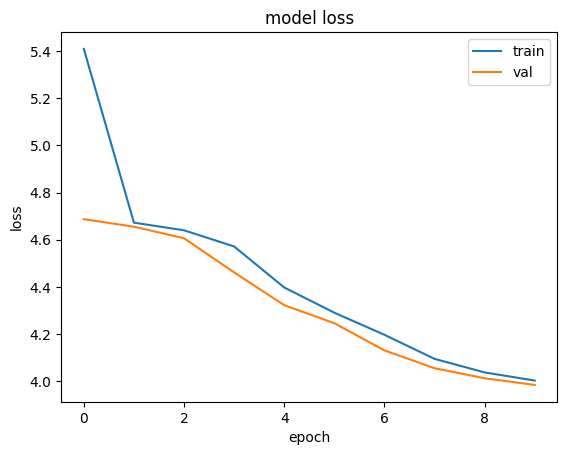

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title('Loss')
axs[0].ylabel('loss')
axs[0].xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper right')

axs[1].plot(history.history['masked_sparse_accuracy'])
axs[1].plot(history.history['val_masked_sparse_accuracy'])
axs[1].title('Accuracy')
axs[1].ylabel('accuracy')
axs[1].xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.show()

In [119]:
text = "hello" #@param {type:"string"}
sample = False #@param {type:"boolean"}

def translate_en_ge(text):
    seq = encode_sequences(eng_tokenizer, en_length, [text])
    probs = model.predict(seq)[0] # (30, 1001)
    # probs = probs / probs.sum(axis=1, keepdims=True)

    ind = [
        np.random.choice(len(ger_tokenizer.vocab), p=prob)
        if sample else np.argmax(prob)
        for prob in probs
    ]
    

    sentence = ger_tokenizer.sequence_to_text(ind)

    return sentence

translation = translate_en_ge(text)

1/1 [==============================] - 0s 64ms/step


In [125]:
translation

'<sos> wie ist ich <unk> oder sehr <unk> hat <eos> sieht <eos> wie wer <eos> geld <eos> <eos> machen die <eos> bibliothek s <eos> <eos> <unk> gleiche <unk> <eos> wurde machen lesen <unk> der möchte stellen <unk> spricht <eos> <eos>'

# FUN WITH TENSOARBOARD

In [127]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [128]:
from tensorboard.plugins import projector

In [129]:
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='/logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for subwords in eng_tokenizer.vocab:
        if subwords != "<unk>":
            f.write("{}\n".format(subwords))


# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
%tensorboard --logdir /logs/